In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(360, 480, 2)
Max:  1
Min:  -1
[[-1  1]
 [ 0  0]
 [ 1  1]]


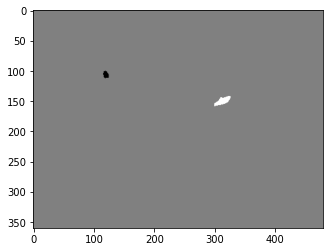

In [9]:
import numpy as np

sample_trend = np.load("/home/tedlasai/genCamera/Animation-from-Blur-main/dataset/b-aist++/gBR_sBM_c01_d04_mBR0_ch01_cropped_32X/trend+_avg/00000000_trend.npy")

print(sample_trend.shape)
print("Max: ", np.max(sample_trend))
print("Min: ", np.min(sample_trend))
import matplotlib.pyplot as plt
plt.imshow(sample_trend[:,:,0], cmap='gray')

unique_colors = np.unique(sample_trend.reshape(-1, sample_trend.shape[2]), axis=0)
print(unique_colors)

In [31]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision.models.optical_flow import raft_large
from PIL import Image

def compute_quantized_flow(imgs, threshold=0.25, device=None):
    """
    Compute averaged flow across adjacent images, threshold small magnitudes, 
    and quantize into 4 diagonal bins.

    Args:
        images:
        threshold    (float):   drop any pixel whose flow magnitude < threshold.
        device       (torch.device or None):  
                              where to run RAFT; if None we pick CUDA if available.

    Returns:
        flow_avg  (np.ndarray[2,H,W]): the mean flow field (after zeroing small vectors).
        quant_img (np.ndarray[H,W,3], dtype=uint8): color image with:
                      [-1,-1]→green, [ 1,-1]→red, [-1, 1]→yellow, [ 1, 1]→blue, zeros→black.
    """
    with torch.no_grad():
        # pick device
        if device is None:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # load RAFT
        model = raft_large(pretrained=True).to(device).eval()


        def flow_pair(im1_np, im2_np):
            im1 = TF.to_tensor(im1_np).unsqueeze(0).to(device)
            im2 = TF.to_tensor(im2_np).unsqueeze(0).to(device)
            flows = model(im1, im2)
            return flows[-1][0].detach().cpu().numpy()  # 2×H×W


        # compute and average flows
        all_flows = [flow_pair(imgs[i], imgs[i+1]) for i in range(len(imgs)-1)]
        flow_avg = np.mean(all_flows, axis=0)  # 2×H×W

        # zero out small motions
        u, v = flow_avg
        mag = np.sqrt(u*u + v*v)
        small = mag < threshold
        u[small] = 0
        v[small] = 0
        flow_avg = np.stack([u, v], axis=0)

        # quantize signs
        su = np.sign(u).astype(int)
        sv = np.sign(v).astype(int)

        # pack into a single array
        quant_flow = np.stack([su, sv], axis=0)  # shape (2, H, W)

        # build viz image
        H, W = su.shape
        quant_img = np.zeros((H, W, 3), dtype=np.uint8)
        quant_img[(su==-1)&(sv==-1)] = [0, 255,   0]  # green  for bottom-left
        quant_img[(su== 1)&(sv==-1)] = [255, 0,   0]  # red    for bottom-right
        quant_img[(su==-1)&(sv== 1)] = [255,255,  0]  # yellow for top-left
        quant_img[(su== 1)&(sv== 1)] = [0,   0, 255]  # blue   for top-right
        # zeros remain black
        torch.cuda.empty_cache()

    return flow_avg, quant_img


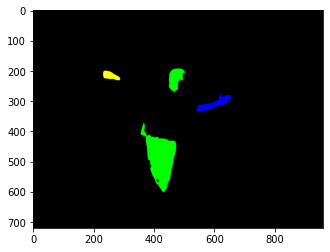

In [33]:
images = ["/home/tedlasai/genCamera/Animation-from-Blur-main/dataset/b-aist++/gBR_sBM_c01_d04_mBR0_ch01_cropped_32X/sharp/00000000_000.png",
          "/home/tedlasai/genCamera/Animation-from-Blur-main/dataset/b-aist++/gBR_sBM_c01_d04_mBR0_ch01_cropped_32X/sharp/00000000_001.png",
          "/home/tedlasai/genCamera/Animation-from-Blur-main/dataset/b-aist++/gBR_sBM_c01_d04_mBR0_ch01_cropped_32X/sharp/00000000_002.png",
          "/home/tedlasai/genCamera/Animation-from-Blur-main/dataset/b-aist++/gBR_sBM_c01_d04_mBR0_ch01_cropped_32X/sharp/00000000_003.png",
          "/home/tedlasai/genCamera/Animation-from-Blur-main/dataset/b-aist++/gBR_sBM_c01_d04_mBR0_ch01_cropped_32X/sharp/00000000_004.png",
          "/home/tedlasai/genCamera/Animation-from-Blur-main/dataset/b-aist++/gBR_sBM_c01_d04_mBR0_ch01_cropped_32X/sharp/00000000_005.png",
          "/home/tedlasai/genCamera/Animation-from-Blur-main/dataset/b-aist++/gBR_sBM_c01_d04_mBR0_ch01_cropped_32X/sharp/00000000_006.png",]
#load all iamges into npy array
def load_images(image_paths):
    images = []
    for path in image_paths:
        img = plt.imread(path)
        images.append(img)
    return np.array(images)

images = load_images(images)
quant_flow, quant_viz = compute_quantized_flow(images, threshold=0.25, device="cuda")
plt.imshow(quant_viz)

In [35]:
from pathlib import Path


def print_tree(path: Path, prefix: str = ""):
    # print folder name
    print(prefix + path.name + "/")
    # increase indent for children
    prefix += "    "
    for child in sorted(path.iterdir()):
        if child.is_dir():
            print_tree(child, prefix)
        else:
            print(prefix + child.name)

if __name__ == "__main__":
    root = Path("/home/tedlasai/genCamera/GOPRO_7")       # or any folder you like
    print_tree(root)

GOPRO_7/
    test/
        blur/
            GOPR0384_11_00/
                000004.png
                000011.png
                000018.png
                000025.png
                000032.png
                000039.png
                000046.png
                000053.png
                000060.png
                000067.png
                000074.png
                000081.png
                000088.png
                000095.png
                000102.png
                000109.png
                000116.png
                000123.png
                000130.png
                000137.png
                000144.png
                000151.png
                000158.png
                000165.png
                000172.png
                000179.png
                000186.png
                000193.png
                000200.png
                000207.png
                000214.png
                000221.png
                000228.png
                000235.png
                00024

KeyboardInterrupt: 